# 2. Subgroup analysis of two-featured model
This notebook is dedicated to a detailed subgroup analysis of the two-featured XGBoost model developed for predicting hypoglycemia risk during exercise in individuals with Type 1 Diabetes. Our focus is on exploring how different subgroups, based on various demographic and clinical factors, respond to the predictive model. This analysis aims to uncover insights into the model's performance across diverse patient profiles and exercise conditions.
Objectives:

1. Data Preparation: Importing necessary packages and datasets, and preparing the data for analysis. This includes merging datasets, handling missing values, and creating relevant subgroups for a comprehensive analysis.

2. Subgroup Categorization: Binning continuous variables such as BMI, HbA1c, and glucose levels into categorical subgroups for nuanced analysis.

3. Subgroup Analysis: Employing the XGBoost model to evaluate its predictive accuracy across various subgroups. This includes computing metrics like ROC AUC scores, Brier scores, and mean error rates.

4. Visualization: Creating forest plots to visually compare the model's performance across different subgroups.

5. Concluding Insights: Summarizing key findings from the subgroup analysis, highlighting any significant differences in model performance across patient categories.

6. The results from this analysis are crucial for understanding the model's utility in real-world settings, ensuring its applicability to a wide range of patients with Type 1 Diabetes.

## 2.0. Packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import forestplot as fp
import sys
sys.path.append("../2_model_building")
import explain_helper

In [2]:
# Upload dataset with predicted probabilities columns
df = pd.read_csv('../../results/probability_results/xgb_two.csv')

In [3]:
# Select subgroups of interest
subgroup_df = df[['bout_id','study', 'age','bmi','sex', 'years_since_diagnosis', 'intensity',  'start_glc','duration','form_of_exercise', 'insulin_modality','time_of_day','hba1c','y', 'probas_xgb_two', 'probas_xgb_two_fold']] #'probas_lr_two','probas_lr_two_fold', 'probas_xgb_ts']]

In [4]:
# ID key
id_key = pd.read_csv('../1_preprocessing/id_key_dexip.csv').drop_duplicates('bout_id')

# Add the ID to the dataset
during_hypo = subgroup_df.merge(id_key, on='bout_id', how='left')

In [5]:
# Glycemic metrics
glycemic_metrics = pd.read_csv('../../results/demographics_table/metrics_glycemic_control.csv')

# Take only CV
cv = glycemic_metrics[['ID', 'CV (%)']]

# Merge
during_hypo = during_hypo.merge(cv, on='ID', how='left')

In [6]:
during_hypo

,bout_id,study,age,bmi,sex,years_since_diagnosis,intensity,start_glc,duration,form_of_exercise,insulin_modality,time_of_day,hba1c,y,probas_xgb_two,probas_xgb_two_fold,ID,start_datetime,finish_datetime,CV (%)
0,dexip_100_20210610130600,dexip,14.0,22.886999,male,13.0,0.0,6.56,20.0,aer,mdi,afternoon,95.62875,False,0.039921,3,dexip_100,2021-08-10 13:06:00,2021-08-10 13:26:00,24.110897
1,dexip_100_20213210153222,dexip,14.0,22.886999,male,13.0,0.0,10.00,15.0,aer,mdi,afternoon,95.62875,False,0.006907,8,dexip_100,2021-08-10 15:32:22,2021-08-10 15:47:22,24.110897
2,dexip_100_20211110191100,dexip,14.0,22.886999,male,13.0,0.0,6.61,25.0,mix,mdi,evening,95.62875,False,0.052547,2,dexip_100,2021-08-10 19:11:00,2021-08-10 19:36:00,24.110897
3,dexip_100_20215811125800,dexip,14.0,22.886999,male,13.0,0.0,8.94,15.0,aer,mdi,afternoon,95.62875,False,0.022215,7,dexip_100,2021-08-11 12:58:00,2021-08-11 13:13:00,24.110897
4,dexip_100_20213511163500,dexip,14.0,22.886999,male,13.0,0.0,7.22,15.0,aer,mdi,afternoon,95.62875,False,0.012402,0,dexip_100,2021-08-11 16:35:00,2021-08-11 16:50:00,24.110897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14942,helm_988_20211504091534,helm,68.0,24.886475,female,16.0,1.0,6.50,70.0,aer,closed_loop,morning,45.35535,True,0.140922,6,helm_988,2021-04-04 09:15:34,2021-04-04 10:25:34,28.314300
14943,helm_988_20213005093035,helm,68.0,24.886475,female,16.0,1.0,6.11,32.0,mix,closed_loop,morning,45.35535,False,0.077352,0,helm_988,2021-04-05 09:30:35,2021-04-05 10:02:35,28.314300
14944,helm_988_20215207115243,helm,68.0,24.886475,female,16.0,1.0,6.94,25.0,aer,closed_loop,morning,45.35535,False,0.049671,3,helm_988,2021-04-07 11:52:43,2021-04-07 12:17:43,28.314300
14945,helm_988_20212907122933,helm,68.0,24.886475,female,16.0,1.0,3.83,25.0,aer,closed_loop,afternoon,45.35535,True,0.657744,5,helm_988,2021-04-07 12:29:33,2021-04-07 12:54:33,28.314300


## 2.1. Bin any continuous subgroups

In [7]:
# bmi
during_hypo['bmi_bin'] = pd.cut(during_hypo['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# hba1c
during_hypo['hba1c_bin'] = pd.cut(during_hypo['hba1c'], bins=[0, 48, float('inf')], labels=['<48', '>=48'])

# cv
during_hypo['cv_bin'] = pd.cut(during_hypo['CV (%)'], bins=[0, 33, float('inf')], labels=['<33', '>=33'])

# start glucose
during_hypo['start_glc_bin'] = pd.cut(during_hypo['start_glc'], bins=[0, 7.8, 10, float('inf')], labels=['<7.8', '7.8-10', '>10'])

# duration
during_hypo['duration_bin'] = pd.cut(during_hypo['duration'],bins=[0, 30, 60, float('inf')], labels=['10-30', '30-60', '>60-90'])# labels=['10-20', '20-30', '30-35', '35-57', '57-120'])

# age
during_hypo['age_bin'] = pd.qcut(during_hypo['age'], 3, labels=['12-25', '25-40', '40-80'])

# years since diagnosis
during_hypo['years_since_diagnosis_bin'] = pd.qcut(during_hypo['years_since_diagnosis'], q=3, labels=['0-10', '11-20', '>20'])

In [11]:
# Rename variables for some cols
during_hypo['form_of_exercise'] = during_hypo['form_of_exercise'].replace({'mix':'Mixed', 'ana':'Anaerobic', 'aer':'Aerobic'})
during_hypo['intensity'] = during_hypo['intensity'].replace({0:'Light', 1:'Moderate', 2:'Vigorous'})

In [12]:
during_hypo

,bout_id,study,age,bmi,sex,years_since_diagnosis,intensity,start_glc,duration,form_of_exercise,...,start_datetime,finish_datetime,CV (%),bmi_bin,hba1c_bin,cv_bin,start_glc_bin,duration_bin,age_bin,years_since_diagnosis_bin
0,dexip_100_20210610130600,dexip,14.0,22.886999,male,13.0,Light,6.56,20.0,Aerobic,...,2021-08-10 13:06:00,2021-08-10 13:26:00,24.110897,Normal,>=48,<33,<7.8,10-30,12-25,11-20
1,dexip_100_20213210153222,dexip,14.0,22.886999,male,13.0,Light,10.00,15.0,Aerobic,...,2021-08-10 15:32:22,2021-08-10 15:47:22,24.110897,Normal,>=48,<33,7.8-10,10-30,12-25,11-20
2,dexip_100_20211110191100,dexip,14.0,22.886999,male,13.0,Light,6.61,25.0,Mixed,...,2021-08-10 19:11:00,2021-08-10 19:36:00,24.110897,Normal,>=48,<33,<7.8,10-30,12-25,11-20
3,dexip_100_20215811125800,dexip,14.0,22.886999,male,13.0,Light,8.94,15.0,Aerobic,...,2021-08-11 12:58:00,2021-08-11 13:13:00,24.110897,Normal,>=48,<33,7.8-10,10-30,12-25,11-20
4,dexip_100_20213511163500,dexip,14.0,22.886999,male,13.0,Light,7.22,15.0,Aerobic,...,2021-08-11 16:35:00,2021-08-11 16:50:00,24.110897,Normal,>=48,<33,<7.8,10-30,12-25,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14942,helm_988_20211504091534,helm,68.0,24.886475,female,16.0,Moderate,6.50,70.0,Aerobic,...,2021-04-04 09:15:34,2021-04-04 10:25:34,28.314300,Normal,<48,<33,<7.8,>60-90,40-80,11-20
14943,helm_988_20213005093035,helm,68.0,24.886475,female,16.0,Moderate,6.11,32.0,Mixed,...,2021-04-05 09:30:35,2021-04-05 10:02:35,28.314300,Normal,<48,<33,<7.8,30-60,40-80,11-20
14944,helm_988_20215207115243,helm,68.0,24.886475,female,16.0,Moderate,6.94,25.0,Aerobic,...,2021-04-07 11:52:43,2021-04-07 12:17:43,28.314300,Normal,<48,<33,<7.8,10-30,40-80,11-20
14945,helm_988_20212907122933,helm,68.0,24.886475,female,16.0,Moderate,3.83,25.0,Aerobic,...,2021-04-07 12:29:33,2021-04-07 12:54:33,28.314300,Normal,<48,<33,<7.8,10-30,40-80,11-20


## 2.2. Subgroup analysis

In [13]:
# Calculate roc and mean error for overall model
sa_all = explain_helper.subgroup_analysis(during_hypo, None)

   probas_xgb_two_fold       roc       bac       mae  ratio_hypos  \
0                    0  0.861882  0.189298 -0.083313     0.090970   
1                    1  0.871728  0.193311  0.340235     0.101003   
2                    2  0.840679  0.210033  0.333311     0.096321   
3                    3  0.860424  0.188629  0.363469     0.099666   
4                    4  0.824968  0.204013 -0.393554     0.093645   
5                    5  0.834879  0.207358  0.374779     0.094314   
6                    6  0.861877  0.218060 -0.980814     0.086957   
7                    7  0.851596  0.211513 -0.119911     0.092369   
8                    8  0.860550  0.192771  0.491733     0.096386   
9                    9  0.818189  0.207497 -0.271685     0.092369   

   ratio_predicted_hypos  bouts  participants  
0               0.091803  14947           754  
1               0.097601  14947           754  
2               0.092988  14947           754  
3               0.096031  14947           754  


In [14]:
# Calculate roc and mean error for subgroups
sa_study= explain_helper.subgroup_analysis(during_hypo, 'study')
sa_intensity = explain_helper.subgroup_analysis(during_hypo, 'intensity')
sa_insulin = explain_helper.subgroup_analysis(during_hypo, 'insulin_modality')
sa_cv = explain_helper.subgroup_analysis(during_hypo, 'cv_bin')
sa_sex = explain_helper.subgroup_analysis(during_hypo, 'sex')
sa_start_glc = explain_helper.subgroup_analysis(during_hypo, 'start_glc_bin')
sa_bmi_bin = explain_helper.subgroup_analysis(during_hypo, 'bmi_bin')
sa_age_bin = explain_helper.subgroup_analysis(during_hypo, 'age_bin')
sa_hba1c_bin = explain_helper.subgroup_analysis(during_hypo, 'hba1c_bin')
sa_form= explain_helper.subgroup_analysis(during_hypo, 'form_of_exercise')
sa_tod = explain_helper.subgroup_analysis(during_hypo, 'time_of_day')
sa_ysd = explain_helper.subgroup_analysis(during_hypo, 'years_since_diagnosis_bin')
sa_duration = explain_helper.subgroup_analysis(during_hypo, 'duration_bin')

   study  probas_xgb_two_fold    roc    bac    mae  ratio_hypos  \
0  dexip                    0  0.872  0.222 -0.892        0.102   
1  dexip                    1  0.875  0.222 -0.105        0.113   
2  dexip                    2  0.814  0.246 -0.339        0.099   
3  dexip                    3  0.830  0.218  2.120        0.116   
4  dexip                    4  0.846  0.225  0.839        0.120   
5  dexip                    5  0.876  0.218  1.246        0.113   
6  dexip                    6  0.886  0.197  0.735        0.106   
7  dexip                    7  0.838  0.240  0.503        0.102   
8  dexip                    8  0.864  0.223  1.266        0.110   
9  dexip                    9  0.839  0.205 -0.673        0.092   

   ratio_predicted_hypos  bouts  participants  
0                  0.111   2837           222  
1                  0.114   2837           222  
2                  0.102   2837           222  
3                  0.095   2837           222  
4                  0.1

In [15]:
# Create column for the group name
sa_all['Group'] = ''
sa_ysd['Group'] = 'Years since diagnosis'
sa_tod['Group'] = 'Time of day'
sa_form['Group'] = 'Type of exercise'
sa_age_bin['Group'] = 'Age (years)'
sa_intensity['Group'] = 'Intensity'
sa_cv['Group'] = 'CV(%)'
sa_study['Group'] = 'Study'
sa_insulin['Group'] = 'Insulin administration'
sa_hba1c_bin['Group'] = 'HbA1c (mmol/mol)'
sa_sex['Group'] = 'Sex'
sa_duration['Group'] = 'Duration'
sa_start_glc['Group'] = 'Starting glucose'


In [16]:
# Combine analysis for subgroups
result_df = pd.concat([sa_all, sa_study,  sa_sex,  sa_age_bin, sa_ysd,  sa_insulin, 
                       sa_cv, sa_hba1c_bin, sa_tod, sa_intensity, sa_form, ], ignore_index=True) # sa_bmi_bin, sa_start_glc, sa_duration

In [17]:
# Rename some subgroups 
result_df['subgroup'] = result_df['subgroup'].str.capitalize()
result_df['subgroup'] = result_df['subgroup'].replace({'All':'All subgroups','Mdi':'MDI', 'Closed_loop':'Closed loop', 
                                                       'Helm':'T1-DEXI', 'Dexip':'T1-DEXIP', 'Ext_101':'EXT-101', 
                                                       'Ext_edu':'EXT-EDU'})

In [18]:
# Convert rate of hypos to percentage
result_df['rate_hypos'] = result_df['rate_hypos']*100

result_df['ratio_predicted_hypos'] = result_df['ratio_predicted_hypos']*100

In [19]:
# Make the ints into strings
result_df.subgroup = result_df.subgroup.astype(str)
result_df.bouts = result_df.bouts.astype(str)
result_df.participants = result_df.participants.astype(str)

In [20]:
abs(result_df.rate_hypos - result_df.ratio_predicted_hypos).max()

2.759999999999999

In [21]:
result_df

,bouts,participants,rate_hypos,rate_hypos-,rate_hypos+,ratio_predicted_hypos,ratio_predicted_hypos-,ratio_predicted_hypos+,roc,roc-,roc+,bac,bac-,bac+,mae,mae-,mae+,subgroup,Group
0,14947,754,9.440008,9.143178,9.736837,9.434583,9.247161,9.622004,0.848677,0.835806,0.861548,0.202248,0.194798,0.209698,0.005425,-0.327807,0.338657,All subgroups,
1,2837,222,10.730000,10.112735,11.347265,10.240000,9.744157,10.735843,0.854000,0.836981,0.871019,0.221600,0.211332,0.231868,0.470000,-0.217486,1.157486,T1-DEXIP,Study
2,414,31,9.170000,6.244889,12.095111,10.880000,9.150341,12.609659,0.848200,0.766384,0.930016,0.229500,0.200494,0.258506,-1.684000,-4.764624,1.396624,EXT-101,Study
3,381,53,11.280000,9.135573,13.424427,9.510000,8.064479,10.955521,0.853300,0.786690,0.919910,0.194500,0.153295,0.235705,1.756800,-0.708490,4.222090,EXT-EDU,Study
4,11315,448,9.070000,8.762683,9.377317,9.180000,8.969945,9.390055,0.846800,0.831769,0.861831,0.196600,0.187223,0.205977,-0.109100,-0.478586,0.260386,T1-DEXI,Study
5,9761,459,8.980000,8.426092,9.533908,8.840000,8.510970,9.169030,0.850100,0.835775,0.864425,0.185400,0.176388,0.194412,0.131600,-0.264368,0.527568,Female,Sex
6,5186,295,10.330000,9.818521,10.841479,10.540000,9.987737,11.092263,0.843600,0.819871,0.867329,0.233800,0.222617,0.244983,-0.227400,-0.938392,0.483592,Male,Sex
7,5365,346,9.620000,9.098885,10.141115,9.330000,8.981093,9.678907,0.847500,0.836218,0.858782,0.201100,0.195534,0.206666,0.296000,-0.332374,0.924374,12-25,Age (years)
8,4709,198,8.650000,8.068597,9.231403,8.920000,8.534326,9.305674,0.855100,0.829756,0.880444,0.192900,0.179047,0.206753,-0.270300,-0.797787,0.257187,25-40,Age (years)
9,4846,209,9.990000,9.363229,10.616771,10.030000,9.689339,10.370661,0.841800,0.821708,0.861892,0.212300,0.198465,0.226135,-0.029200,-0.725852,0.667452,40-80,Age (years)


In [22]:
# Round results to 2 dps
result_df = result_df.round(2)

result_df['rate_hypos'] = result_df.apply(
    lambda row: f"{row['rate_hypos']:.1f} ({row['rate_hypos-']:.1f} to {row['rate_hypos+']:.1f})", axis=1)

result_df['ratio_predicted_hypos'] = result_df.apply(
    lambda row: f"{row['ratio_predicted_hypos']:.1f} ({row['ratio_predicted_hypos-']:.1f} to {row['ratio_predicted_hypos+']:.1f})", axis=1)



# Round rate of hypos to 1 dp
#result_df['rate_hypos'] = result_df['rate_hypos'].round(1)
#result_df['ratio_predicted_hypos'] = result_df['ratio_predicted_hypos'].round(1)

In [23]:
# Rearrange the order of some subgroups
result_df.iloc[1], result_df.iloc[2], result_df.iloc[3], result_df.iloc[4] = result_df.iloc[4], result_df.iloc[1], result_df.iloc[2], result_df.iloc[3]
result_df.iloc[20], result_df.iloc[21], result_df.iloc[22] = result_df.iloc[22], result_df.iloc[20], result_df.iloc[21]
result_df.iloc[13], result_df.iloc[14], result_df.iloc[15] =  result_df.iloc[14], result_df.iloc[15], result_df.iloc[13],

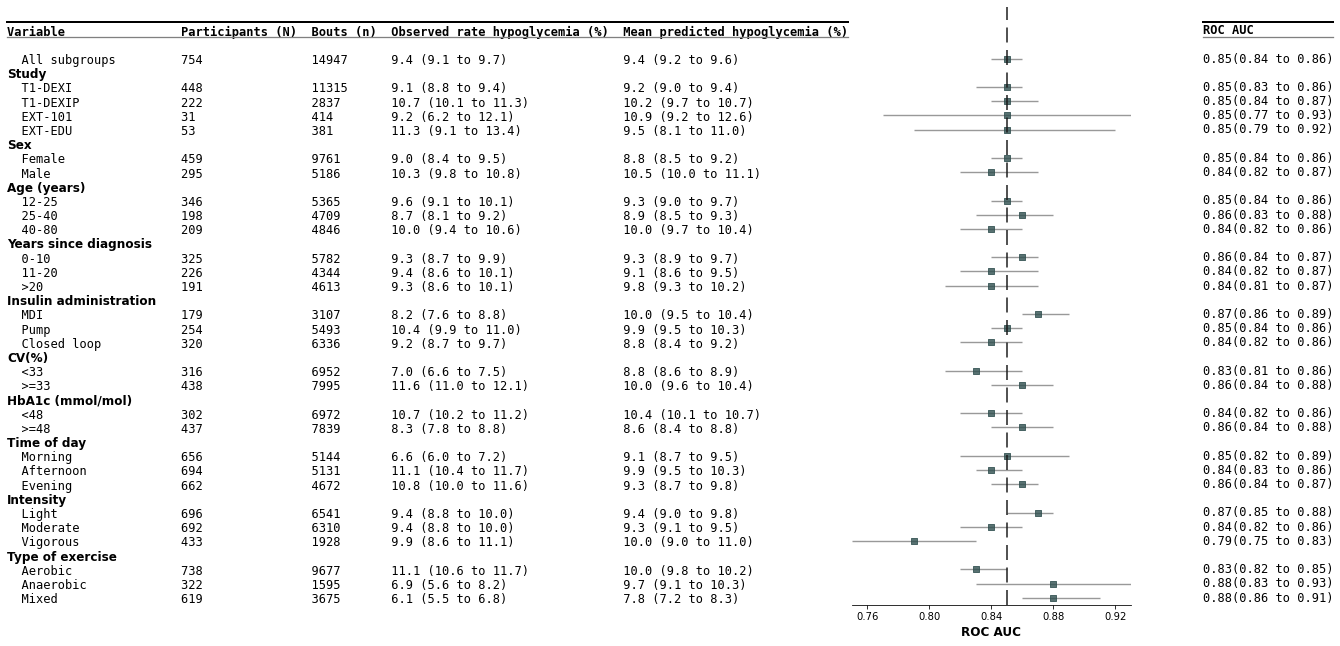

In [24]:
# Reset the font settings to the default
fp.forestplot(result_df,  # the dataframe with results data
              estimate="roc",  # col containing estimated effect size 
              ll="roc-", hl="roc+",  # columns containing conf. int. lower and higher limits
              varlabel="subgroup",  # column containing variable label,
              xlabel="ROC AUC",
              #capitalize="capitalize",  # Capitalize labels
              table=True,
              annote=["participants", "bouts", "rate_hypos", 'ratio_predicted_hypos', ],#"est_ci"
              annoteheaders=["Participants (N)", "Bouts (n)", "Observed rate hypoglycemia (%)", 'Mean predicted hypoglycemia (%)', ],#'ROC AUC'
              rightannote=["est_ci"],
              right_annoteheaders=['ROC AUC'], # (95% CI)
              #color_alt_rows=True,  # Gray alternate rows
              groupvar='Group',              
              figsize=(5,11),
              )
plt.axvline(x=0.85, color=".1", linestyle=(0, (10, 5)))

#plt.tight_layout()
plt.savefig('../../results/figs/fig_2.pdf', bbox_inches='tight')

## 2.2. Brier score

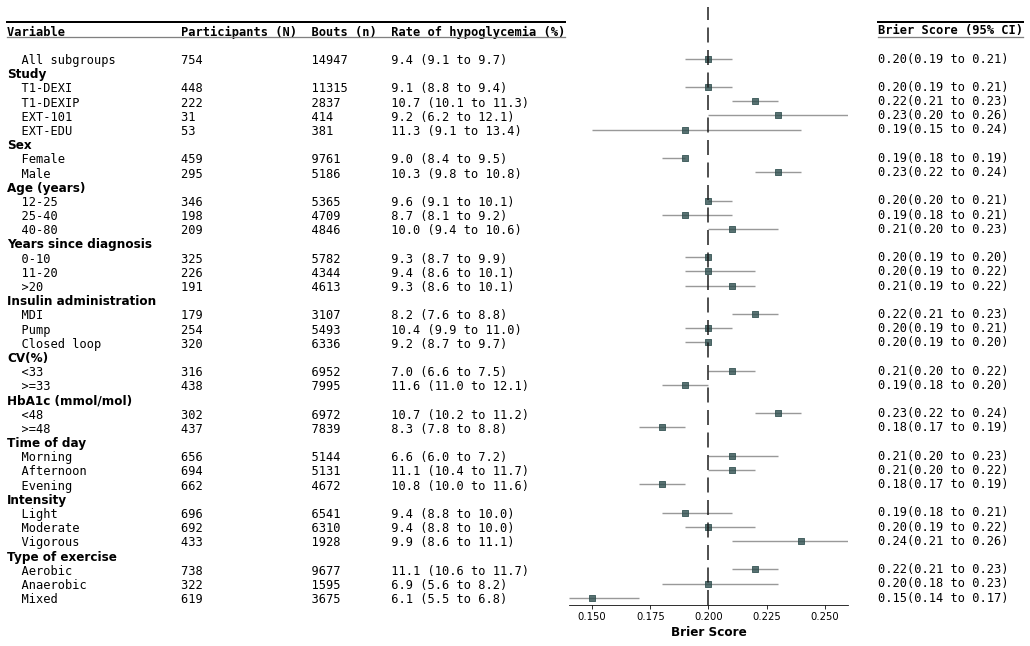

In [25]:
# Reset the font settings to the default
fp.forestplot(result_df,  # the dataframe with results data
              estimate="bac",  # col containing estimated effect size 
              ll="bac-", hl="bac+",  # columns containing conf. int. lower and higher limits
              varlabel="subgroup",  # column containing variable label,
              xlabel="Brier Score",
              #capitalize="capitalize",  # Capitalize labels
              table=True,
              annote=["participants", "bouts", "rate_hypos"],
              annoteheaders=["Participants (N)", "Bouts (n)", "Rate of hypoglycemia (%)"],
              rightannote=["est_ci"],
              right_annoteheaders=['Brier Score (95% CI)'],
              #color_alt_rows=True,  # Gray alternate rows
              groupvar='Group',              
              figsize=(5,11),
                
              )
plt.axvline(x=0.2, color=".1", linestyle=(0, (10, 5)))

#plt.tight_layout()
#plt.savefig('../../results/figs/fig_2.pdf', bbox_inches='tight')

## 2.3. Percentage mean error

In [26]:
result_df[['mae', 'mae+','mae-']] = result_df[['mae', 'mae-','mae+']]*-1

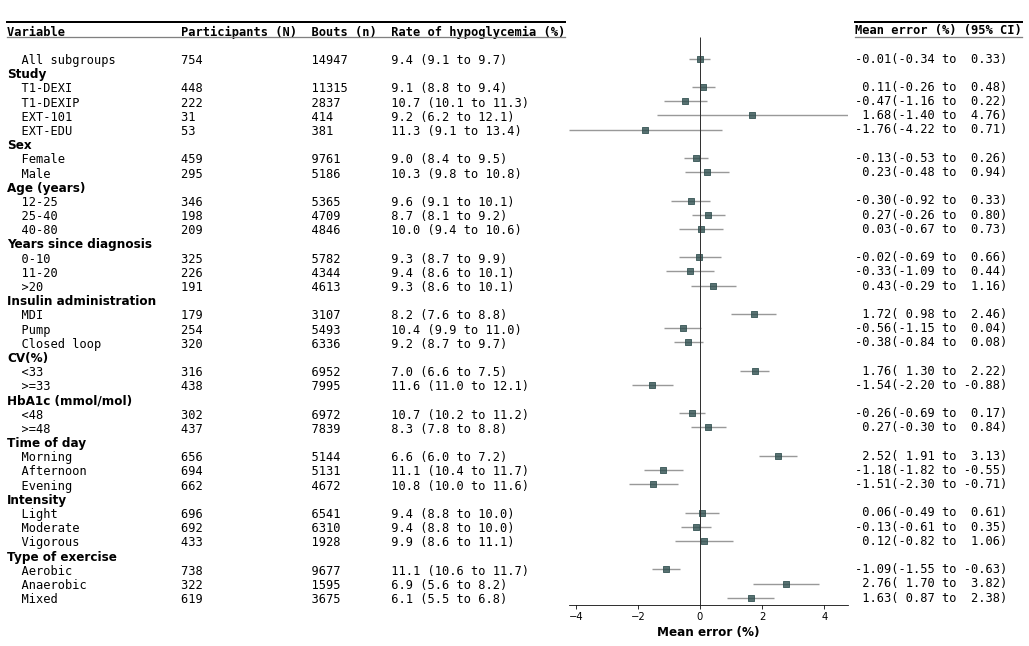

In [27]:
fp.forestplot(result_df,  # the dataframe with results data
              estimate="mae",  # col containing estimated effect size 
              ll="mae-", hl="mae+",  # columns containing conf. int. lower and higher limits
              varlabel="subgroup",  # column containing variable label,
              xlabel="Mean error (%)",
              #capitalize="capitalize",  # Capitalize labels
              table=True,
              annote=["participants", "bouts", "rate_hypos"],
              annoteheaders=["Participants (N)", "Bouts (n)", "Rate of hypoglycemia (%)"],
              rightannote=["est_ci"],
              right_annoteheaders=['Mean error (%) (95% CI)'],
              #color_alt_rows=True,  # Gray alternate rows
              groupvar='Group',              
              figsize=(5,11)  
              )

#plt.tight_layout()
plt.savefig('../../results/figs/suppl_fig_4.pdf', bbox_inches='tight')